In [1]:
import numpy as np
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

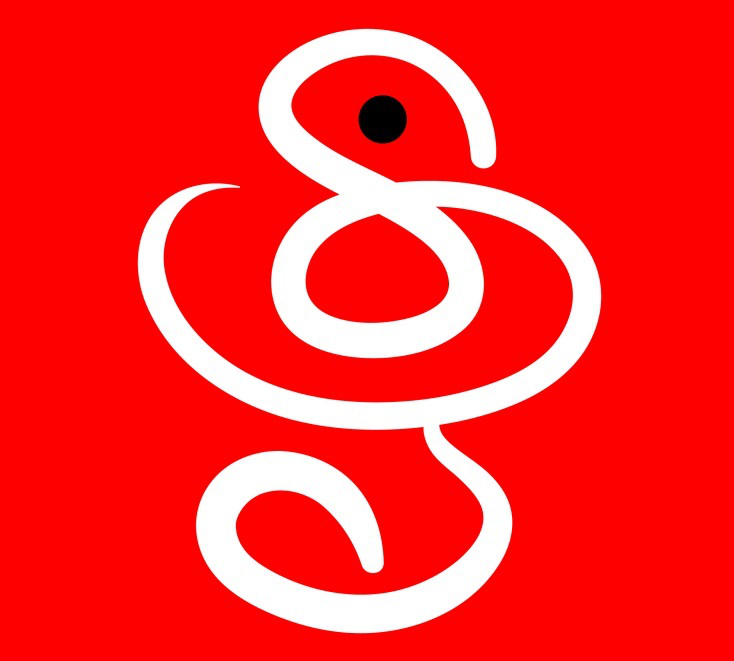

In [2]:
img = Image.open("tamil.jpg")
img

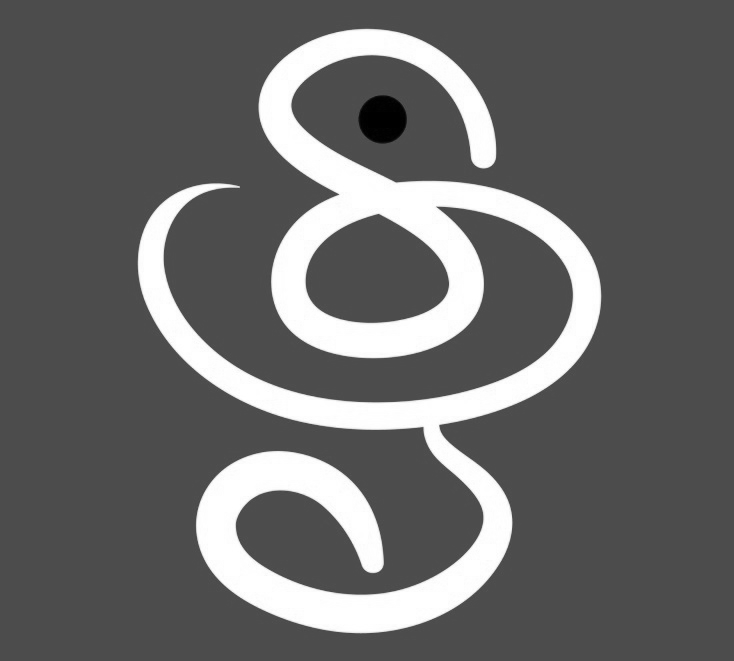

In [3]:
img = img.convert('LA')
img

In [4]:
width = img.width
height = img.height
size = width*height
size

485174

In [5]:
#histogram function 
img = np.array(img)
flat = img.flatten() #image slicing into 1D 

def get_histogram(image, bins):
    count = np.zeros(bins) # array with size of bins, set to zeros
    # loop through pixels and sum up counts of pixels
    for pixel in image:
        count[pixel] += 1
    return count

count = get_histogram(flat, 256)

In [6]:
print(count[0])
prob_count = count/size
print(prob_count[0])

582.0
0.001199569638933661


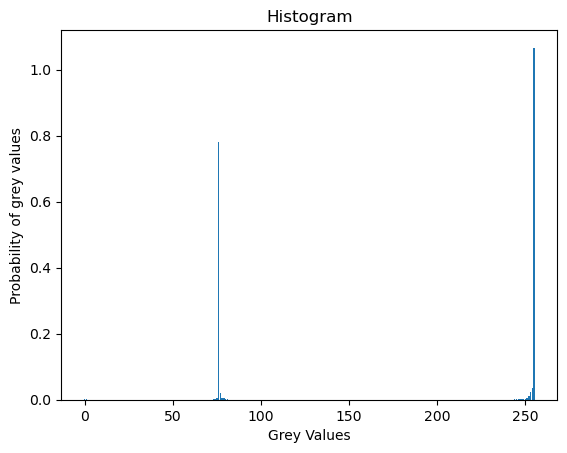

In [7]:
x_axis = np.arange(0,256)
plt.bar(x_axis,prob_count)
plt.title("Histogram")
plt.xlabel("Grey Values")
plt.ylabel("Probability of grey values")
plt.show()

In [8]:
cdf = np.zeros(256)
cdf[0] = prob_count[0]
for i in range(1,len(prob_count)):
    cdf[i] = cdf[i-1]+prob_count[i]
#print(cdf)

In [9]:
transformed_greyval = cdf*7
#print(transformed_greyval)

In [10]:
equalized_histval = np.round_(transformed_greyval) 
#print(equalized_histval)

In [11]:
eq_val = dict()
for i in range(256):
    eq_val[i]=0
for i,j in enumerate(equalized_histval):
    #print(i,j)
    eq_val[j] += prob_count[i]
#print(eq_val.items())

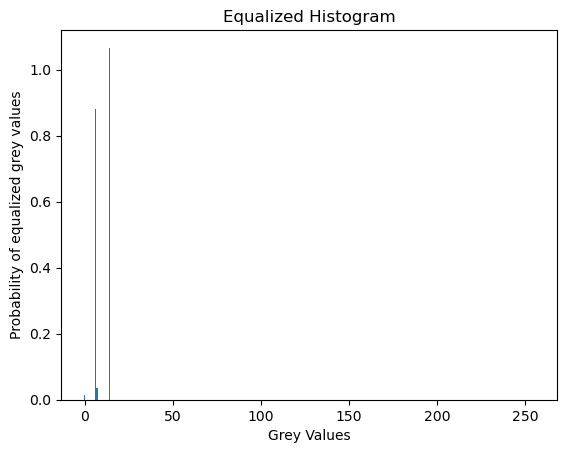

In [12]:
x_axis = eq_val.keys()
y_axis = eq_val.values()
plt.bar(x_axis, y_axis)
plt.title("Equalized Histogram")
plt.xlabel("Grey Values")
plt.ylabel("Probability of equalized grey values")
plt.show()

In [13]:
cdf = np.cumsum(list(eq_val.values()))
cdf_normalized = cdf / cdf.max()
threshold_value = np.argmax(cdf_normalized > 0.5) 
print("Threshold value:", threshold_value)


Threshold value: 14


#### Adaptive Thresholding

In [14]:
img = cv.imread('tamil.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [15]:
#apply normal and adaptive thresholding to the image
ret, thresh = cv.threshold(gray, threshold_value, 255, cv.THRESH_BINARY)
adapt = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C,
                             cv.THRESH_BINARY,99,3)

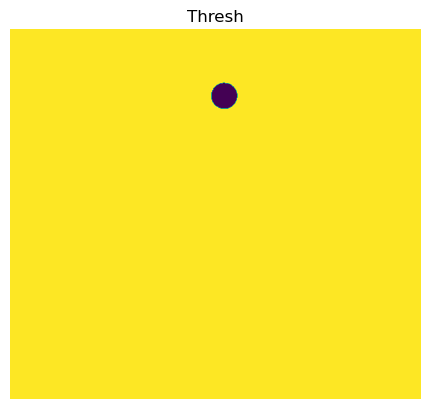

In [16]:
plt.imshow(thresh)
plt.title('Thresh')
plt.axis('off')
plt.show()

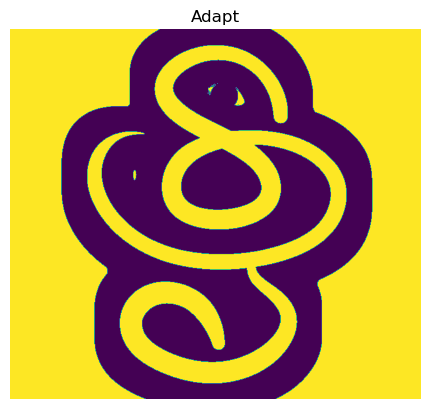

In [17]:
plt.imshow(adapt)
plt.title('Adapt')
plt.axis('off')
plt.show()

#### Watershed Algorithm

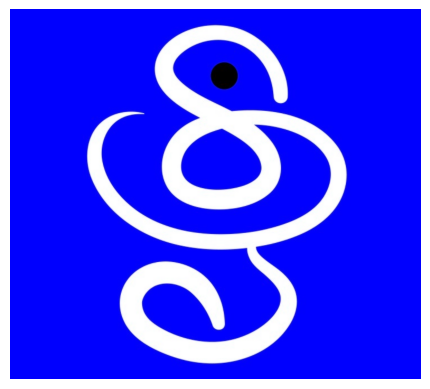

In [18]:
img2 = cv.imread('tamil.jpg')
plt.imshow(img2)
plt.axis('off')
plt.show()

In [19]:
gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

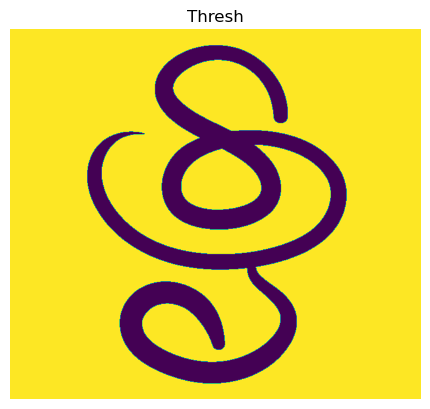

In [20]:
# Threshold using OTSU
ret, thresh = cv.threshold(gray, 0, 255, 
                            cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plt.imshow(thresh)
plt.title('Thresh')
plt.axis('off')
plt.show()

In [21]:
'''1. Creation of kernel'''
kernel = np.ones( (3,3), np.uint8)
#creates a 3x3 square kernel where all elements are 1.

In [22]:
'''2. Applying the opening operation'''
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN, kernel, iterations=2)
#thresh is the binary image obtained after thresholding
#kernel is our structuring element

In [23]:
'''3. Dilation for Background Identification'''
sure_bg = cv.dilate(opening, kernel)
#dilation operation is used to identify the bg region of the img
#result of previous step is subjected to dilation
#dilation expands the objects and a significant portion around the
#objects is expected to be the background region

In [24]:
'''4. Distance Transformation'''
dist_transform = cv.distanceTransform(opening, cv.DIST_L2,5)
'''
The cv2.distanceTransform function calculates the distance from each
binary image pixel to the nearest zero pixel using the cv2.DIST_L2 
(Euclidean distance)'''

'''
The distance transform helps us identify regions that are likely to
be in the foreground. The function cv2.distanceTransform
(opening, cv2.DIST_L2, 5) calculates this transform.'''

ret, sure_fg = cv.threshold(
    dist_transform, 0.7 * dist_transform.max(), 255, 0)
'''
After calculating the distance transform, we apply thresholding to 
this transformed image to get the sure foreground region.'''
'''The cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0) 
function call applies the thresholding. The second parameter 
0.7*dist_transform.max() sets the threshold level at 70% of the 
max dist found by the dist transform. Pixels with dist 
transform values higher than this threshold are set as sure fg.'''

'The cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0) \nfunction call applies the thresholding. The second parameter \n0.7*dist_transform.max() sets the threshold level at 70% of the \nmax dist found by the dist transform. Pixels with dist \ntransform values higher than this threshold are set as sure fg.'

In [25]:
'''5. Identify unknown regions'''
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

'''We identify the unknown region, i.e., the region that is neither 
sure foreground nor sure background. We first convert the sure 
foreground (sure_fg) into an unsigned 8-bit integer. 
We then subtract the sure foreground from the sure background
(sure_bg) to get the unknown region. 

The unknown region is key for the Watershed algorithm because it 
signifies the transition region between distinct objects or between 
an object and the background.'''

'We identify the unknown region, i.e., the region that is neither \nsure foreground nor sure background. We first convert the sure \nforeground (sure_fg) into an unsigned 8-bit integer. \nWe then subtract the sure foreground from the sure background\n(sure_bg) to get the unknown region. \n\nThe unknown region is key for the Watershed algorithm because it \nsignifies the transition region between distinct objects or between \nan object and the background.'

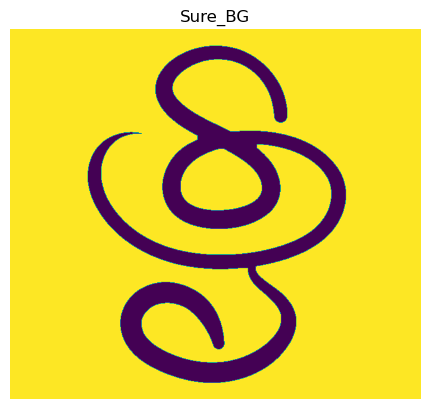

In [26]:
plt.imshow(sure_bg)
plt.title('Sure_BG')
plt.axis('off')
plt.show()

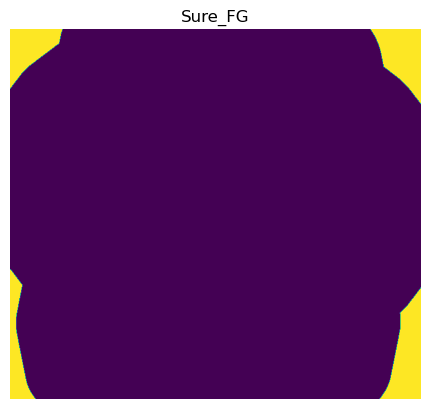

In [27]:
plt.imshow(sure_fg)
plt.title('Sure_FG')
plt.axis('off')
plt.show()

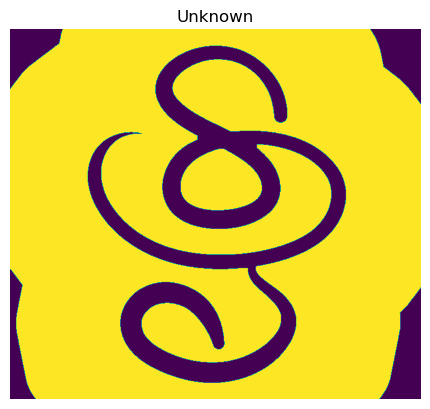

In [28]:
plt.imshow(unknown)
plt.title('Unknown')
plt.axis('off')
plt.show()

In [29]:
'''6. Label sure_bg, sure_fg and unknown regions'''
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

'''
This involves creating a marker and labeling the regions inside it
The regions we mark are the sure background (sure_bg), sure 
foreground (sure_fg), and the unknown regions.'''

'\nThis involves creating a marker and labeling the regions inside it\nThe regions we mark are the sure background (sure_bg), sure \nforeground (sure_fg), and the unknown regions.'

In [30]:
'''7. Watershed Algorithm'''
markers = cv.watershed(img2,markers)
img2[markers == -1] = [255,0,0]

#imshow("img", img)

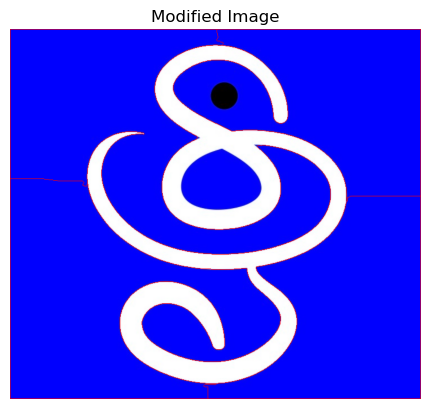

In [31]:
plt.imshow(img2)
plt.title('Modified Image')
plt.axis('off')
plt.show()

circular structural element

In [32]:
img2 = cv.imread('tamil.jpg')
gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

In [33]:
# Threshold using OTSU
ret, thresh = cv.threshold(gray, 0, 255, 
                            cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

In [34]:
# Function to create a circular structuring element
def create_circular_kernel(radius):
    diameter = 2 * radius + 1
    kernel = np.zeros((diameter, diameter), dtype=np.uint8)
    center = (radius, radius)
    cv.circle(kernel, center, radius, 1, thickness=-1)
    return kernel

radius = 5  # Adjust the radius as needed
kernel = create_circular_kernel(radius)

In [35]:
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv.dilate(opening, kernel)
dist_transform = cv.distanceTransform(opening, cv.DIST_L2,5)
ret, sure_fg = cv.threshold(
    dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)
ret, markers = cv.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0
markers = cv.watershed(img2,markers)
img2[markers == -1] = [255,0,0]

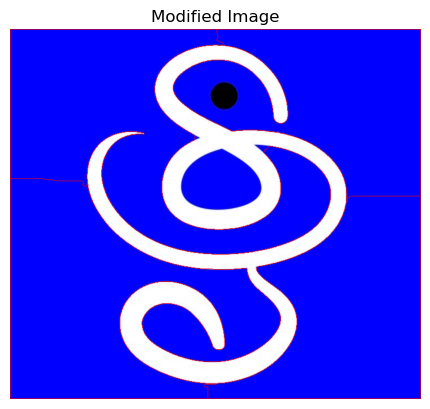

In [36]:
plt.imshow(img2)
plt.title('Modified Image')
plt.axis('off')
plt.show()